# PROJEKT PRI FINANČNEM PRAKTIKUMU
Najprej izberemo število točk $n = 3k$ za $k$ iz naravnih števil. Nato naključno generiramo te točke in jih zapišemo v slovar $p$.
Ključi slovarja so števila od 0 do $n-1$, vrednosti pa $x$ in $y$ koordinate točk.


In [32]:
# za merjenje časa, ki ga porabi program potrebujemo uvoziti:
import time

n = 15

if n <= 0:
    print("Napaka: število točk mora biti pozitivno")
elif n % 3 != 0:
    print("Napaka: izbrati je treba 3k število točk za k iz naravnih števil")
else:
    print("Uspešno izbrano število točk")

p = {i: (random(), random()) for i in range(n)}

# Nato definiramo matriko M v katero bomo zapisali vse razdalje med točkami.
M = matrix(RR,n)

# Sledeča zanka v matriko M zapiše razdalje 
for i in range(n):
    for j in range(n):
        M[i,j] = (((p[i][0])-(p[j][0]))^2 + ((p[i][1])-(p[j][1]))^2)^((0.5))

        
# Naprej nas zanima ali se dve povezavi med seboj sekata. V ta namen definiramo funkcijo 'seka', ki nam 
# pove ali daljica ij seka daljico lk, kjer so i,j,k,l števila med 0 in n-1.       
def zasuk(a,b,c):
    A = matrix(RR,3)
    A[0] = (1, p[a][0],p[a][1])
    A[1] = (1, p[b][0],p[b][1])
    A[2] = (1, p[c][0],p[c][1])
    return(det(A))

def seka(a,b,c,d):
    if zasuk(a,b,c)*zasuk(a,b,d)<0 and zasuk(a,c,d)*zasuk(b,c,d)<0:
        return(1)
    else:
        return(0)

Uspešno izbrano število točk


## Maksimizacija vsote robov
Definiramo celoštevilski linearni program, ki maksimira vsoto dolžin vseh povezav, ki jih bomo uporabili.

In [24]:
start = time.time()

clp = MixedIntegerLinearProgram(maximization=True)

# Definiramo spremenljivko x, ki zavzame vrednost 0 ali 1
x = clp.new_variable(binary=True)

# Dodamo pogoje, ki jih je potrebno upoštevati v našem programu:

#  1) Iz vsake točke lahko gresta natanko 2 povezavi, ali pa vanjo pride natanko 1 povezava.
for i in range(n):
    clp.add_constraint(sum(x[i, j] + 2*x[j, i] for j in range(n)) == 2)
    
#  2) Če se dve povezavi sekata, je lahko uporabljena zgolj ena izmed niju.
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                clp.add_constraint(x[i,j]+x[j,i]+x[k,l]+x[l,k]+seka(i,j,k,l)<=2)
                
                
# Dodamo cilj našega programa. V našem primeru maksimum vsote uporabljenih povezav.
clp.set_objective(sum(x[i, j]*M[i,j] for i in range(n) for j in range(n)))

# Izračunamo vrednost vsote.
vsota = clp.solve()
print(f'Vsota povezav je {vsota}')

end = time.time()
print(f"Program porabi {end - start}")


Vsota povezav je 4.791692235310732
Program porabi 188.6267113685608


In [25]:
# Pogledamo katere povezave smo uporabili.
povezave = clp.get_values(x)
povezave1 = {k:v for k, v in povezave.items() if v == 1}
povezave1.keys()

dict_keys([(4, 0), (1, 5), (1, 12), (8, 2), (4, 3), (6, 10), (6, 14), (13, 7), (8, 9), (13, 11)])

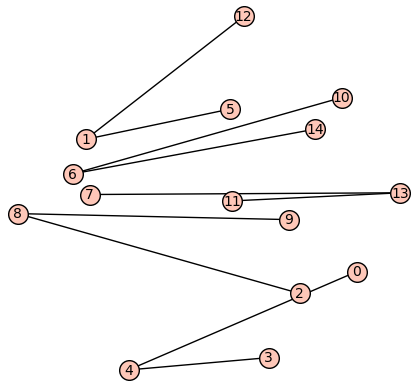

In [26]:
# Narišemo graf, ki prikazuje izbrane točke in povezave.
G = Graph([e for e, v in clp.get_values(x).items() if v == 1])
G._pos = p
G.plot()

# Maksimizacija najkrajšega roba
V tem primeru bomo povezave izbrali tako, da bomo maksimirali dolžino najkrajše izbrane povezave.

In [27]:
start2 = time.time()

clp2 = MixedIntegerLinearProgram(maximization=True)

# Definiramo spremenljivko y, ki zavzame vrednost 0 ali 1
y = clp2.new_variable(binary=True)

# Definiramo realno nenegativno spremenljivko w
w = clp2.new_variable(real=True, nonnegative=True)

# Definiramo spremenljivko Mmax, ki je najdaljša možna povezave med izbranimi točkami
Mmax = max(M[i,j] for i in range(n) for j in range(n))

# Dodamo pogoje, ki jih je potrebno upoštevati v našem programu:

#  1) Iz vsake točke lahko gresta natanko 2 povezavi, ali pa vanjo pride natanko 1 povezava.
for i in range(n):
    clp2.add_constraint(sum(y[i, j] + 2*y[j, i] for j in range(n)) == 2)
    
#  2) Če se dve povezavi sekata, je lahko uporabljena zgolj ena izmed niju.
for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                clp2.add_constraint(y[i,j]+y[j,i]+y[k,l]+y[l,k]+seka(i,j,k,l)<=2)
                
#  3) Spremenljivka w bo vedno manjša ali enaka najkrajši povezavi, ki jo bomo uporabili (za katero je y[i,j] == 1).
for i in range(n):
    for j in range(n):
        clp2.add_constraint(w[1] <= M[i, j] + (1 - y[i, j]) * Mmax)
        
# Kot cilj maksimiramo velikost w, kar maksimira dolžino najkrajše uporabljene povezave.
clp2.set_objective(w[1])

# Dobimo dolžino najkrajše uporabljene povezave.
dolzina = clp2.solve()
print(f'Dolžina najkrajše uporabljene povezave je {dolzina}')

end2 = time.time()
print(f"Program porabi {end2 - start2}")

Dolžina najkrajše uporabljene povezave je 0.2922753602640863
Program porabi 465.20815420150757


In [28]:
# Pogledamo katere povezave smo uporabili.
povezave2 = clp2.get_values(y)
povezave3 = {k:v for k, v in povezave2.items() if v == 1}
povezave3.keys()

dict_keys([(8, 0), (1, 5), (1, 12), (4, 2), (4, 3), (6, 10), (6, 14), (13, 7), (8, 9), (13, 11)])

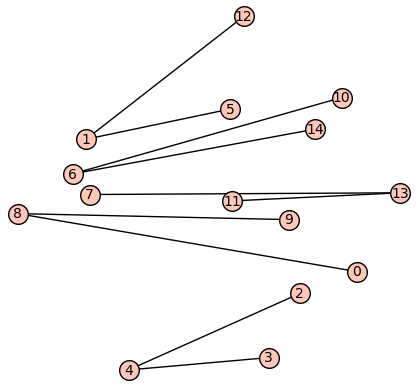

In [29]:
# Narišemo graf, ki prikazuje izbrane točke in povezave.
G2 = Graph([e for e, v in clp2.get_values(y).items() if v == 1])
G2._pos = p
G2.plot()

## Primerjava vsot in časov postopkov

In [31]:
# Za primer maksimiranja najkrajše povezave izračunamo še vsoto vseh uporabljenih povezav in jo primerjamo s prejšnjo
def getList(povezave3):
    list1 = []
    for key in povezave3.keys():
        list1.append(key)
    return list1

list1 = getList(povezave3)

vsota2 = sum(M[list1[i][0],list1[i][1]] for i in range(n*(2/3)))

razmerje_vsot = vsota/vsota2
print(f'Vsota iz maksimiranja vsote {vsota}')
print(f'Vsota iz maksimiranja najkrajše povezave {vsota2}' )      
print(f'Razmerje vsot {razmerje_vsot}')
print(f"Program maksimiranja vsot porabi {end - start} sekund")
print(f"Program maksimiranja najkrajše povezave porabi {end2 - start2} sekund")
print(f'Razmerje časov {(end-start)/(end2-start2)}')

Vsota iz maksimiranja vsote 4.791692235310732
Vsota iz maksimiranja najkrajše povezave 4.77056361811011
Razmerje vsot 1.00442895617625
Program maksimiranja vsot porabi 188.6267113685608 sekund
Program maksimiranja najkrajše povezave porabi 465.20815420150757 sekund
Razmerje časov 0.40546733685767694
